Labeled sequence of bitter peptides.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import scikitplot as skplt

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

In [4]:
train_pos = pd.read_csv('train-positive.txt', header=None)
train_neg = pd.read_csv('train-negative.txt', header=None)
test_pos = pd.read_csv('test-positive.txt', header=None)
test_neg = pd.read_csv('test-negative.txt', header=None)

In [5]:
train_pos = pd.DataFrame([train_pos[::2].reset_index(drop=True)[0], train_pos[1::2].reset_index(drop=True)[0]]).T
train_neg = pd.DataFrame([train_neg[::2].reset_index(drop=True)[0], train_neg[1::2].reset_index(drop=True)[0]]).T
test_pos = pd.DataFrame([test_pos[::2].reset_index(drop=True)[0], test_pos[1::2].reset_index(drop=True)[0]]).T
test_neg = pd.DataFrame([test_neg[::2].reset_index(drop=True)[0], test_neg[1::2].reset_index(drop=True)[0]]).T

In [6]:
df = test_neg.append(test_pos).append(train_pos).append(train_neg).reset_index(drop=True)
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: x.split(' ')[0][1:])
df.columns = ['bitter', 'seq']
df

,bitter,seq
0,Negative,AA
1,Negative,IKP
2,Negative,ILP
3,Negative,PFFDPQIP
4,Negative,IPQEVLP
...,...,...
635,Negative,NPPHQIYP
636,Negative,AIYK
637,Negative,ENGLPVHLDQSIFRRP
638,Negative,AMKPW


In [7]:
df = df.sample(frac=1)

In [8]:
df = df.sample(frac=1)
labels = df.bitter.apply(lambda x: 1 if x=='Positive' else 0).values
seq = df.seq.values

In [9]:
descriptors = list(set([j for i in seq for j in i]))
enc = OneHotEncoder()
X = np.array(descriptors).reshape((-1, 1))
enc_arrays = enc.fit(X)

In [10]:
def create_graph_data(str, label):
    n = len(str)
    edge_index_up = [[i, i+1] for i in range(n-1)]
    edge_index_down = [[i+1, i] for i in range(n-1)]
    edge_index = torch.tensor(edge_index_down + edge_index_up, dtype=torch.long)

    node_feats = enc.transform([[i] for i in str]).toarray()
    node_features = torch.tensor(node_feats, dtype=torch.float) 
    label = torch.tensor(label)
    d = Data(x = node_features, edge_index=edge_index.t().contiguous(), y = label)

    return(d)

In [11]:
data_list = []

In [12]:
for i in range(len(labels)):
    d = create_graph_data(seq[i], labels[i])

    data_list.append(d)

In [13]:
train_data, test_data = train_test_split(data_list, test_size=0.1)

In [14]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle = True)

In [15]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[350, 20], edge_index=[2, 572], y=[64], batch=[350], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[349, 20], edge_index=[2, 570], y=[64], batch=[349], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(x=[358, 20], edge_index=[2, 588], y=[64], batch=[358], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(x=[364, 20], edge_index=[2, 600], y=[64], batch=[364], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(x=[323, 20], edge_index=[2, 518], y=[64], batch=[323], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(x=[343, 20], edge_index=[2, 558], y=[64], batch=[343], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(x=[367, 20], edge_index=[2, 606], y=[64], batch=[367], ptr=[65])

Step 8:
Number of graphs in the current batch: 64
DataBatch(x=[303, 20], edge_index=[2, 478], y=[64], batch=[303], ptr

In [16]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(20, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(20, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [17]:
model = GCN(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 20):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.7465, Test Acc: 0.7500
Epoch: 002, Train Acc: 0.8194, Test Acc: 0.8281
Epoch: 003, Train Acc: 0.8247, Test Acc: 0.8281
Epoch: 004, Train Acc: 0.8576, Test Acc: 0.8125
Epoch: 005, Train Acc: 0.8611, Test Acc: 0.7812
Epoch: 006, Train Acc: 0.8802, Test Acc: 0.8281
Epoch: 007, Train Acc: 0.8889, Test Acc: 0.8281
Epoch: 008, Train Acc: 0.8819, Test Acc: 0.8438
Epoch: 009, Train Acc: 0.8906, Test Acc: 0.8125
Epoch: 010, Train Acc: 0.9236, Test Acc: 0.7812
Epoch: 011, Train Acc: 0.9184, Test Acc: 0.8281
Epoch: 012, Train Acc: 0.9184, Test Acc: 0.7812
Epoch: 013, Train Acc: 0.8733, Test Acc: 0.8281
Epoch: 014, Train Acc: 0.9097, Test Acc: 0.8281
Epoch: 015, Train Acc: 0.8611, Test Acc: 0.8594
Epoch: 016, Train Acc: 0.9271, Test Acc: 0.7969
Epoch: 017, Train Acc: 0.9340, Test Acc: 0.8125
Epoch: 018, Train Acc: 0.9427, Test Acc: 0.8125
Epoch: 019, Train Acc: 0.9410, Test Acc: 0.8438


In [18]:
for data in test_loader:
    out = model(data.x, data.edge_index, data.batch)
    lab = data.y

In [19]:
out.shape

torch.Size([64, 2])

In [20]:
lab.shape

torch.Size([64])

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

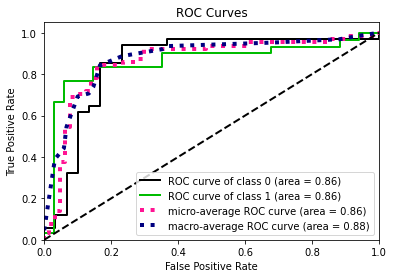

In [21]:
skplt.metrics.plot_roc(lab, out.detach().numpy())

In [22]:
model

GCN(
  (conv1): GCNConv(20, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)

In [23]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

In [24]:
train_graph_embeddings = []
for data in train_loader:
    out = model(data.x, data.edge_index, data.batch)
    lab = data.y

    model.conv3.register_forward_hook(get_activation('conv3'))
    output = model(data.x, data.edge_index, data.batch)
    conv3_feats = activation['conv3']

    for i in torch.unique(data.batch):
        node_indexes = (data.batch == i).nonzero().ravel()

        original_enc = data.x[node_indexes]


        desc = ''.join(list(enc.inverse_transform(original_enc).ravel()))

        d = {'desc':desc, 'n_nodes':len(node_indexes), 'label':lab[i].tolist(), 'conv3_feats':conv3_feats[node_indexes]}
        train_graph_embeddings.append(d)
len(train_graph_embeddings)    

576

In [25]:
test_graph_embeddings = []
for data in test_loader:
    out = model(data.x, data.edge_index, data.batch)
    lab = data.y

    model.conv3.register_forward_hook(get_activation('conv3'))
    output = model(data.x, data.edge_index, data.batch)
    conv3_feats = activation['conv3']

    for i in torch.unique(data.batch):
        node_indexes = (data.batch == i).nonzero().ravel()

        original_enc = data.x[node_indexes]


        desc = ''.join(list(enc.inverse_transform(original_enc).ravel()))

        d = {'desc':desc, 'n_nodes':len(node_indexes), 'label':data.y[i], 'conv3_feats':conv3_feats[node_indexes]}
        test_graph_embeddings.append(d)
len(test_graph_embeddings)    

64

In [26]:
all_graph_embeddings = test_graph_embeddings + train_graph_embeddings

In [27]:
descs = []
conv_feats = np.zeros((len(all_graph_embeddings), 64))
labels = []
for i in range(len(all_graph_embeddings)):
    descs.append(all_graph_embeddings[i]['desc'])
    conv_feats[i] = all_graph_embeddings[i]['conv3_feats'].mean(axis = 0).detach().tolist()
    labels.append(all_graph_embeddings[i]['label'])

### TSNE

In [28]:
tsne_embd = TSNE(n_components=2, random_state=911).fit_transform(conv_feats)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [29]:
tsne_embd.shape

(640, 2)

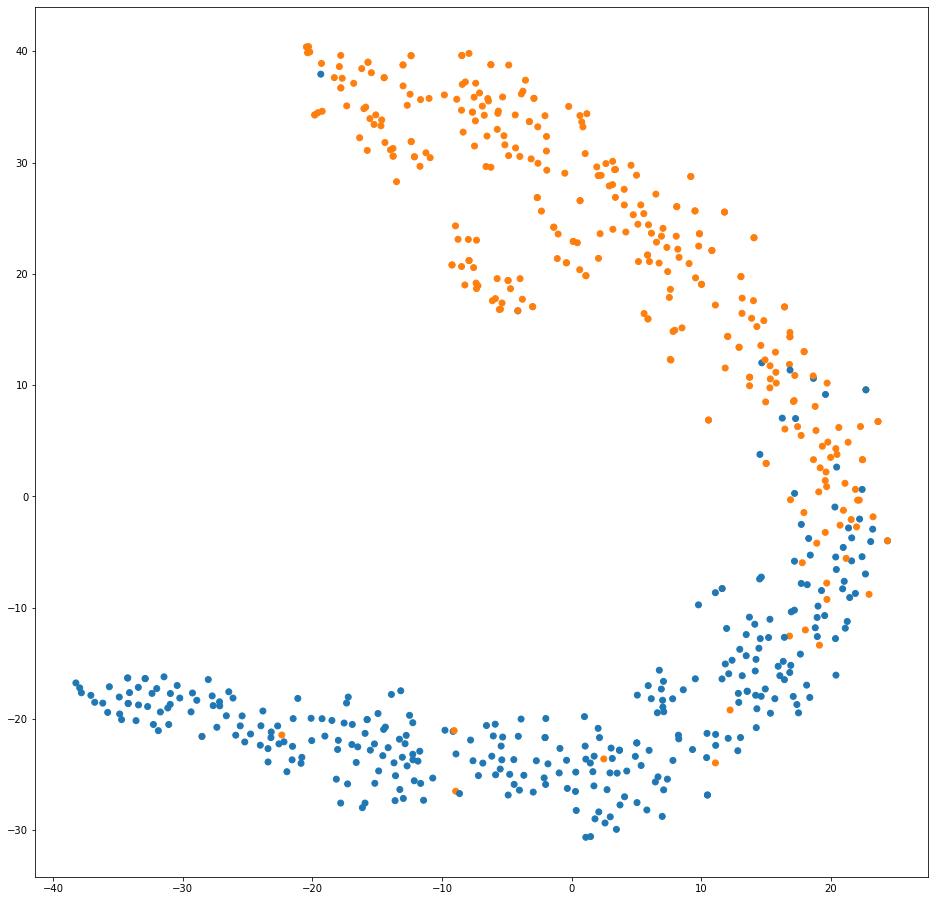

In [33]:
plt.figure(figsize=(16, 16))
plt.scatter(tsne_embd[:, 0], tsne_embd[:, 1], c=[sns.color_palette()[x] for x in labels])
#for i, l in enumerate(descs):
#    plt.annotate(l, (tsne_embd[i, 0], tsne_embd[i, 1]))

### PCA

In [32]:
pca_embd = PCA(n_components=2).fit_transform(conv_feats)

In [105]:
pca_embd.shape

(640, 2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


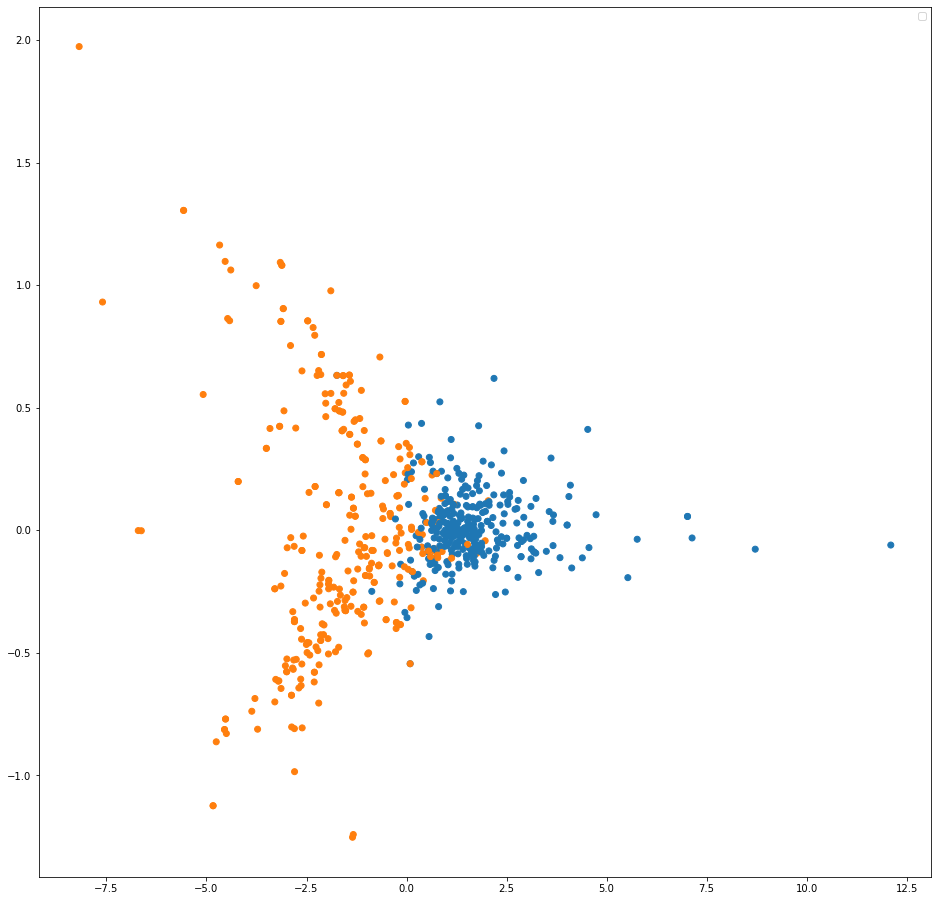

In [106]:
plt.figure(figsize=(16, 16))
plt.scatter(pca_embd[:, 0], pca_embd[:, 1], c=[sns.color_palette()[x] for x in labels])
plt.legend()

#for i, l in enumerate(descs):
#    plt.annotate(l, (pca_embd[i, 0], pca_embd[i, 1]))